In [40]:
import torch
from torch import nn
from tqdm.auto import tqdm
import torchvision.utils as vutils
from collections import OrderedDict
from torchvision.utils import make_grid

# Not neccesary for deployment
import numpy as np
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=64, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=2, stride=2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride=1),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        generated = self.gen(x)
        return generated

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
      n_samples: the number of samples to generate, a scalar
      z_dim: the dimension of the noise vector, a scalar
      device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [5]:
z_dim = 64
display_step = 50
batch_size = 64
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
image_size = 16
workers = 2

gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
#summary(gen, (64,64,64))
#crit = Critic().to(device) 
#crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

#custom weights initialization called on netG and netD
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
        
gen = gen.apply(weights_init)

In [6]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 1, 16)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [7]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

# Load model
gen.load_state_dict(torch.load('../Model/gen2'))

<All keys matched successfully>

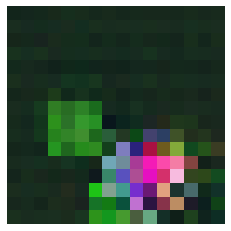

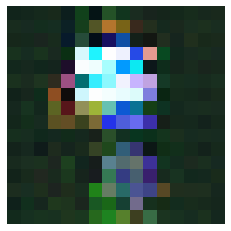

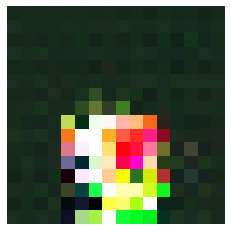

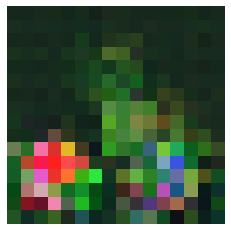

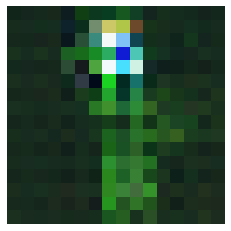

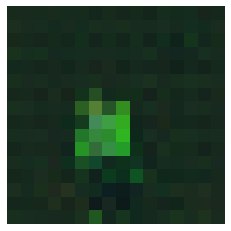

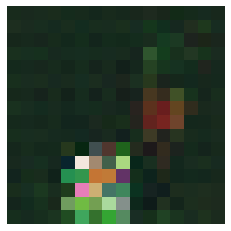

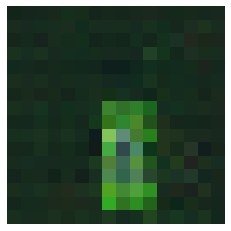

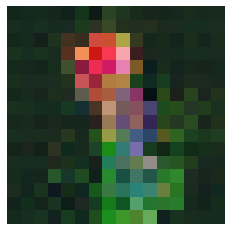

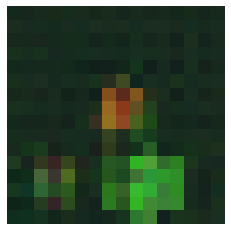

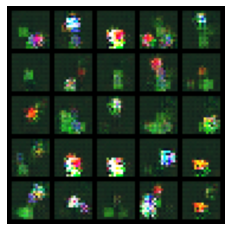

In [149]:
fake_noise = get_noise(64, 64, device=device)
fake = gen(fake_noise)
for i in range(10):
  show_tensor_images(fake[i])
show_tensor_images(fake)

In [156]:
fake_test = torch.where(fake[1] < float(-0.55), -torch.ones_like(fake[1]), fake[1])

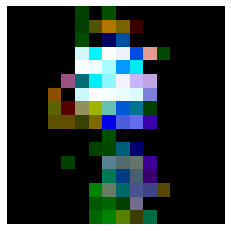

In [157]:
show_tensor_images(fake_test)

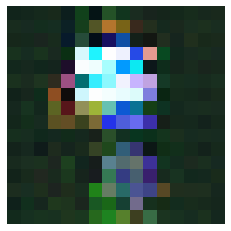

In [159]:
show_tensor_images(fake[1])

In [160]:
!jupyter serverextension enable voila --sys-prefix

Enabling: voila
- Writing config: D:\anaconda3\etc\jupyter
    - Validating...
      voila 0.2.4 ok


In [162]:
from torchvision.widgets import *

ModuleNotFoundError: No module named 'torchvision.widgets'